In [1]:
from pymarketng.application.Mechanism import *
from pymarketng.application.BidManager import BidManager
from pymarketng.application.Plot import plot_demand_curves, plot_trades_as_graph

from pymarketng.domain.Bid import Bid
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
from typing import Callable, List, Type


### Load Dataset

In [2]:
df = pd.read_csv('final_df.csv')


### Create df for each user

In [3]:
users_type1=[]
users_type2=[]
users_type3=[]
num_rows = df.shape[0]
for i in range(0,28):
    if df[f'type_user{i}'][0] == 3:
        user_dict_type3= {
            "time":df['time'],
            "Is_Peak":df[f'is_peak_user{i}'],
            "Load":df[f'load_user{i}'],
            "Generate":df[f'generate_user{i}'],
            "SOC":df[f'SOC_user{i}'],
            "Unit":df[f'unit_user{i}'],
            "Price":df[f'price_user{i}'],
            "Is_Seller":df[f'is_seller_user{i}'],
            "User": i
        }
        users_type3.append(pd.DataFrame(user_dict_type3))
    elif df[f'type_user{i}'][0] == 2:
        user_dict_type2= {
            "time":df['time'],
            "Is_Peak":df[f'is_peak_user{i}'],
            "Load":df[f'load_user{i}'],
            "Generate":df[f'generate_user{i}'],
            "Unit":df[f'unit_user{i}'],
            "Price":df[f'price_user{i}'],
            "Is_Seller":df[f'is_seller_user{i}'],
            "User": i
        }
        users_type2.append(pd.DataFrame(user_dict_type2))

    elif df[f'type_user{i}'][0] == 1:
        user_dict_type1= {
            "time":df['time'],
            "Is_Peak":df[f'is_peak_user{i}'],
            "Load":df[f'load_user{i}'],
            "Unit":df[f'unit_user{i}'],
            "Price":df[f'price_user{i}'],
            "User": i,
            "Is_Seller": False
        }

        users_type1.append(pd.DataFrame(user_dict_type1))


### conver list to pd and save as a csv file

In [4]:

df_Type1 = pd.concat(users_type1)
df_Type2 = pd.concat(users_type2)
df_Type3 = pd.concat(users_type3)
time_list = df_Type2['time'].unique()
full_df = pd.concat([df_Type1, df_Type2, df_Type3])
df_Type1.to_csv('users_type1.csv', index=False)
df_Type2.to_csv('users_type2.csv', index=False)
df_Type3.to_csv('users_type3.csv', index=False)  
df_Type1       


,time,Is_Peak,Load,Unit,Price,User,Is_Seller
0,4/5/2013 0:00,False,194,194,5.187391,20,False
1,4/5/2013 1:00,False,222,222,4.670167,20,False
2,4/5/2013 2:00,False,223,223,3.419582,20,False
3,4/5/2013 3:00,False,194,194,4.794849,20,False
4,4/5/2013 4:00,False,235,235,3.128094,20,False
...,...,...,...,...,...,...,...
67,4/7/2013 19:00,True,1382,1382,153.362647,27,False
68,4/7/2013 20:00,True,754,754,82.977889,27,False
69,4/7/2013 21:00,True,744,744,80.506533,27,False
70,4/7/2013 22:00,False,847,847,12.059464,27,False


### Max and Min Price

In [5]:
Max_price_seller = 0
Max_price_buyer = 0
Min_price_seller = 100000000000
Min_price_buyer = 100000000000
full_df = pd.concat([df_Type1, df_Type2, df_Type3])  
# full_df
Min_price_seller = full_df[full_df['Is_Seller'] == True]['Price'].min()
Max_price_seller = full_df[full_df['Is_Seller'] == True]['Price'].max()
Min_price_buyer = full_df[(full_df['Is_Seller'] == False) & (full_df['Price'] > 0)]['Price'].min()
Max_price_buyer = full_df[full_df['Is_Seller'] == False]['Price'].max()
print('Max_price_buyer:',Max_price_buyer)
print('Min_price_buyer',Min_price_buyer)
print('Max_price_seller:',Max_price_seller)
print('Min_price_seller',Min_price_seller)
P_fit = 0.05
p_G = 900

Max_price_buyer: 773.232621
Min_price_buyer 0.016183986
Max_price_seller: 531.3846531
Min_price_seller 0.055099455


In [6]:
# mean price for each time in all days weighted moving average 
# plot for each time 
#  
# def split_time():
#     full_df = 

/tmp/ipykernel_1680649/1466964772.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  buyers['year'] = buyers['time'].dt.year
/tmp/ipykernel_1680649/1466964772.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  buyers['month'] = buyers['time'].dt.month
/tmp/ipykernel_1680649/1466964772.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

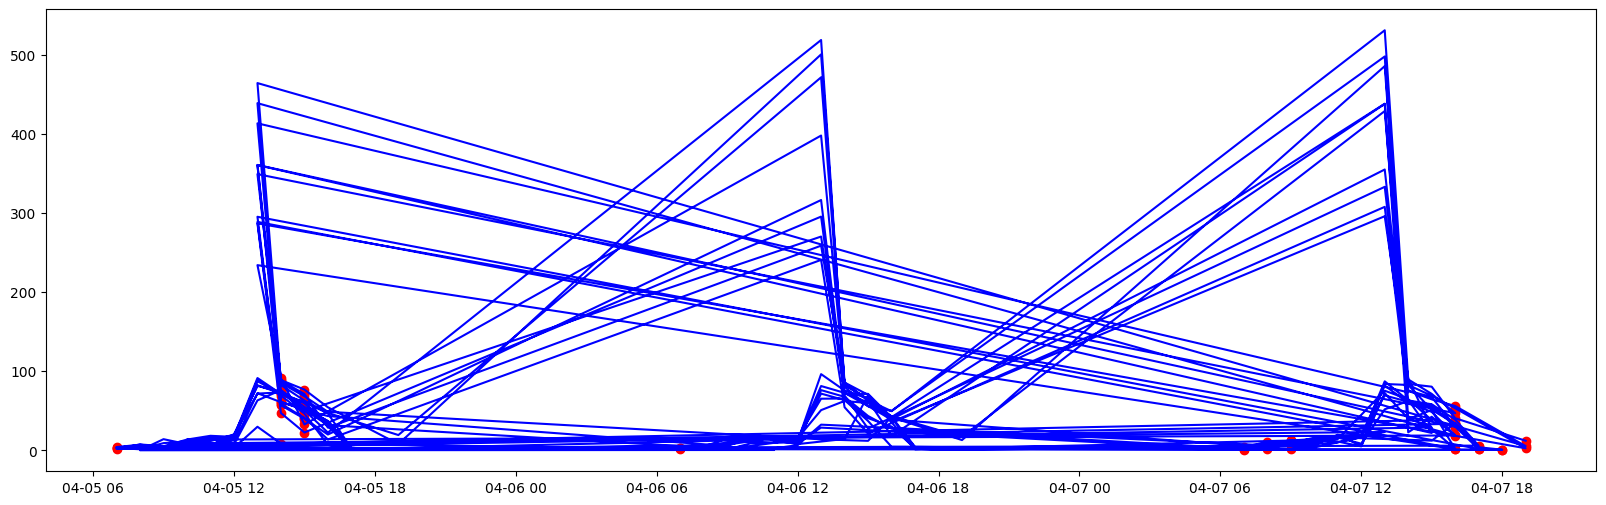

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM


# Convert 'time' column to datetime
full_df['time'] = pd.to_datetime(full_df['time'])
buyers = full_df[full_df['Is_Seller'] == True]

# Extract numerical features from 'time'
buyers['year'] = buyers['time'].dt.year
buyers['month'] = buyers['time'].dt.month
buyers['day'] = buyers['time'].dt.day
buyers['hour'] = buyers['time'].dt.hour
# Add more features as needed

# Select 'price' and extracted time features from df_Type1
data = buyers[['Price', 'year', 'month', 'day', 'hour']]

# Standardize the data
scaler = StandardScaler()
np_scaled = scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

# Train OneClassSVM
model = OneClassSVM(nu=0.3, kernel="rbf", gamma=0.01)
model.fit(data)

# Predict anomalies
buyers['anomaly'] = pd.Series(model.predict(data))

# Plot anomalies
fig, ax = plt.subplots(figsize=(20,6))
anomaly_data = buyers.loc[buyers['anomaly'] == -1, ['time', 'Price']] # Anomalies
ax.plot(buyers['time'], buyers['Price'], color='blue')
ax.scatter(anomaly_data['time'], anomaly_data['Price'], color='red')

plt.show()


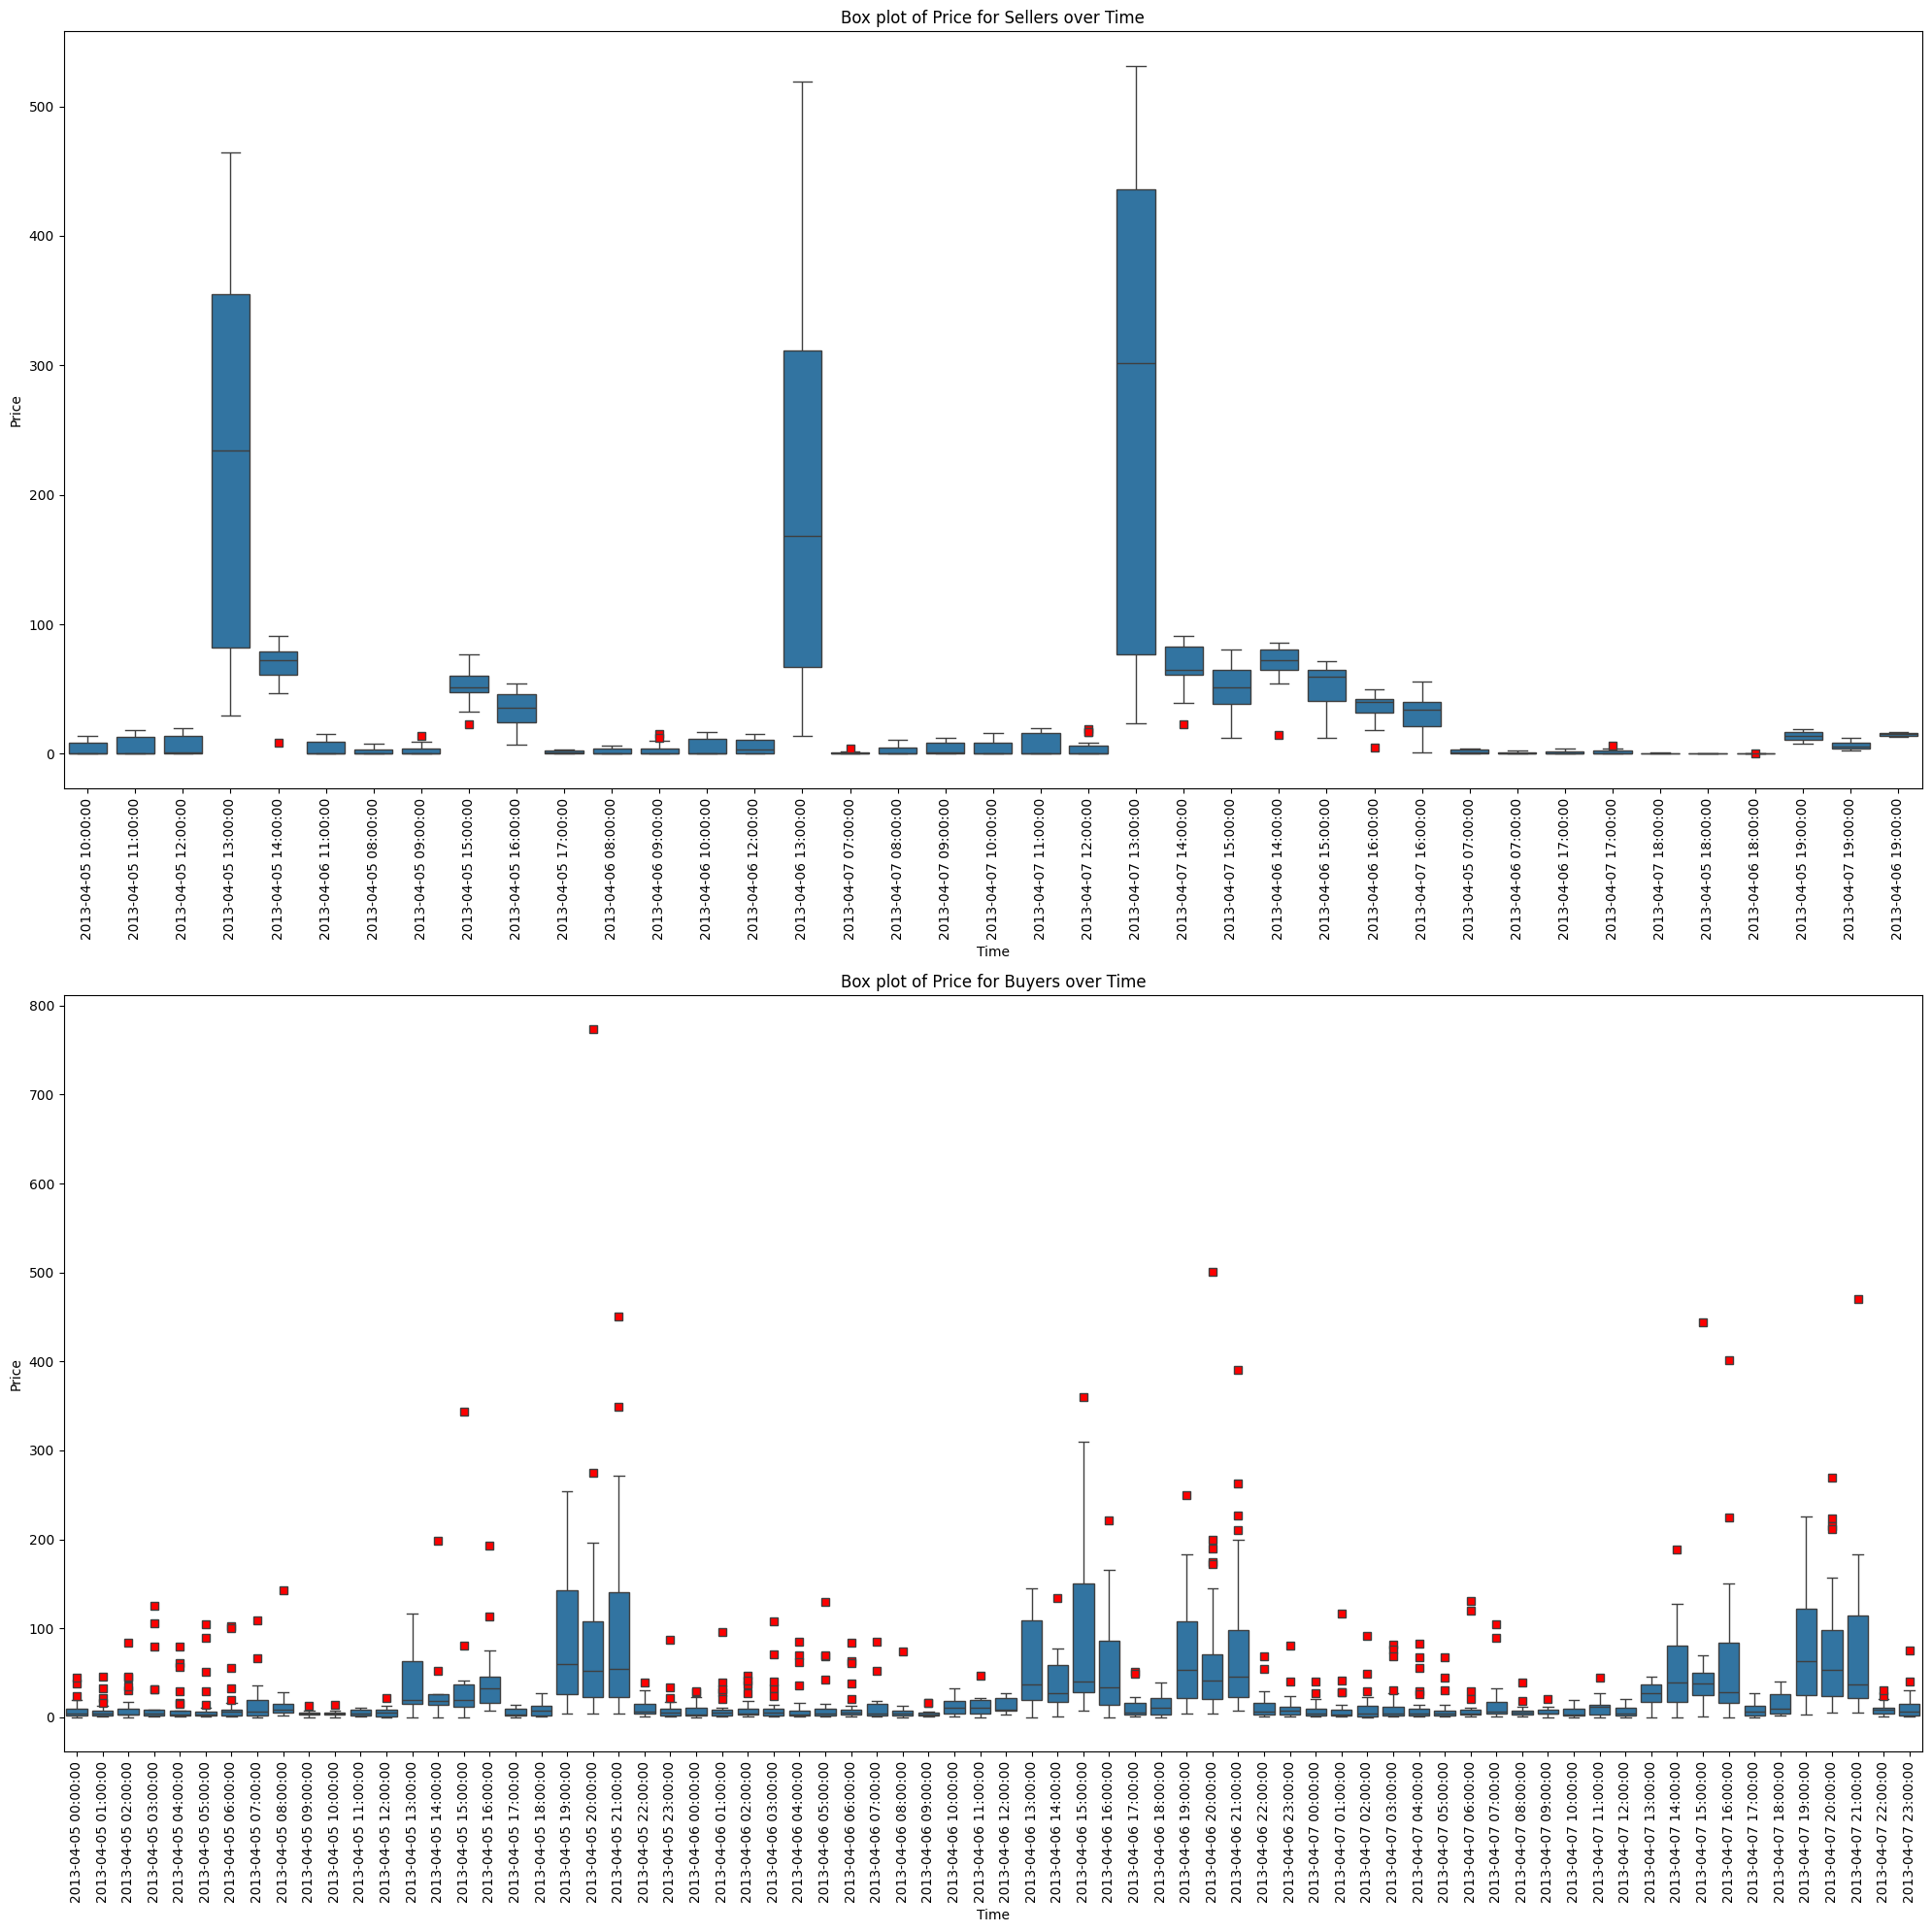

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert 'Is_Seller' column to 'Seller' and 'Buyer'
full_df['Role'] = full_df['Is_Seller'].apply(lambda x: 'Seller' if x else 'Buyer')

fig, axes = plt.subplots(2, 1, figsize=(20, 20))

# Create a box plot for 'Price' for 'Seller' for each 'time'
sns.boxplot(x='time', y='Price', data=full_df[full_df['Role'] == 'Seller'], ax=axes[0], flierprops=dict(markerfacecolor='r', marker='s'))
axes[0].set_title('Box plot of Price for Sellers over Time')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Price')
axes[0].tick_params(axis='x', rotation=90)  # Rotate x-axis labels for better visibility

# Create a box plot for 'Price' for 'Buyer' for each 'time'
sns.boxplot(x='time', y='Price', data=full_df[full_df['Role'] == 'Buyer'], ax=axes[1], flierprops=dict(markerfacecolor='r', marker='s'))
axes[1].set_title('Box plot of Price for Buyers over Time')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Price')
axes[1].tick_params(axis='x', rotation=90)  # Rotate x-axis labels for better visibility

plt.tight_layout()
plt.show()

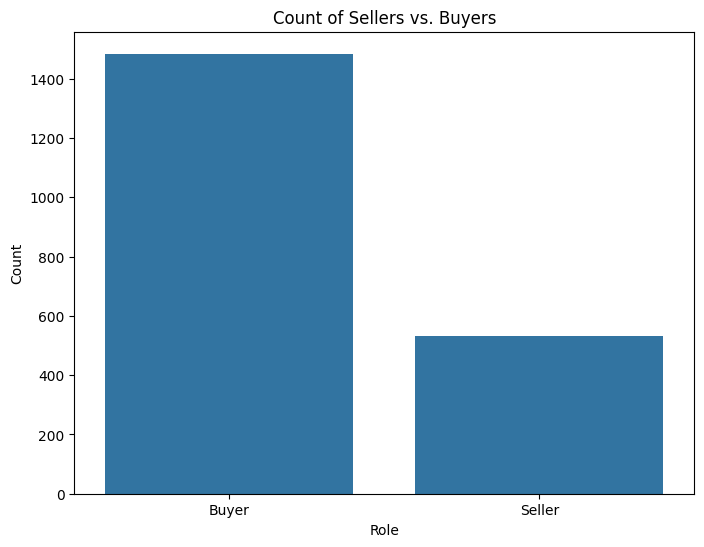

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.countplot(x='Role', data= full_df)
plt.title('Count of Sellers vs. Buyers')
plt.xlabel('Role')
plt.ylabel('Count')
plt.show()

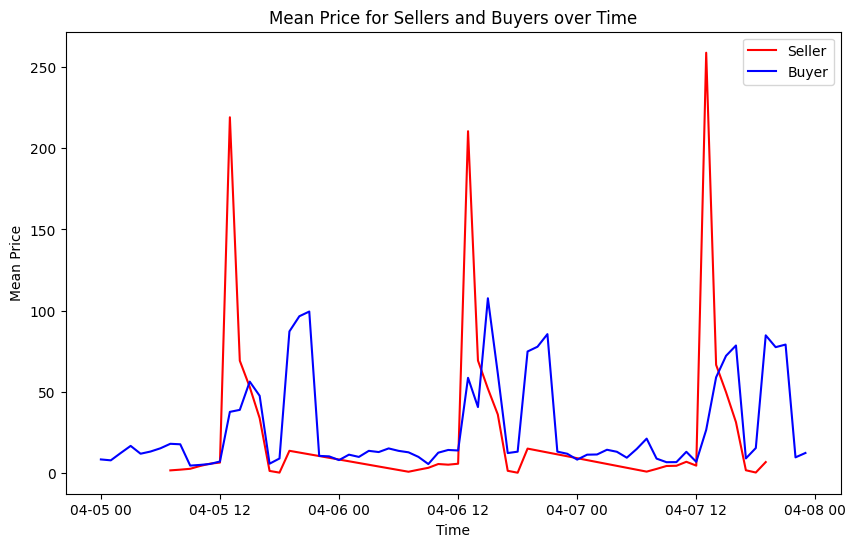

In [10]:
import matplotlib.pyplot as plt

# Group by 'Role' and 'time', calculate mean price
mean_price = full_df.groupby(['Role', 'time'])['Price'].mean().reset_index()

# Plot mean price for sellers and buyers over time
plt.figure(figsize=(10, 6))
for role, color in zip(['Seller', 'Buyer'], ['red', 'blue']):
    subset = mean_price[mean_price['Role'] == role]
    plt.plot(subset['time'], subset['Price'], color=color, label=role)

plt.title('Mean Price for Sellers and Buyers over Time')
plt.xlabel('Time')
plt.ylabel('Mean Price')
plt.legend()
plt.show()

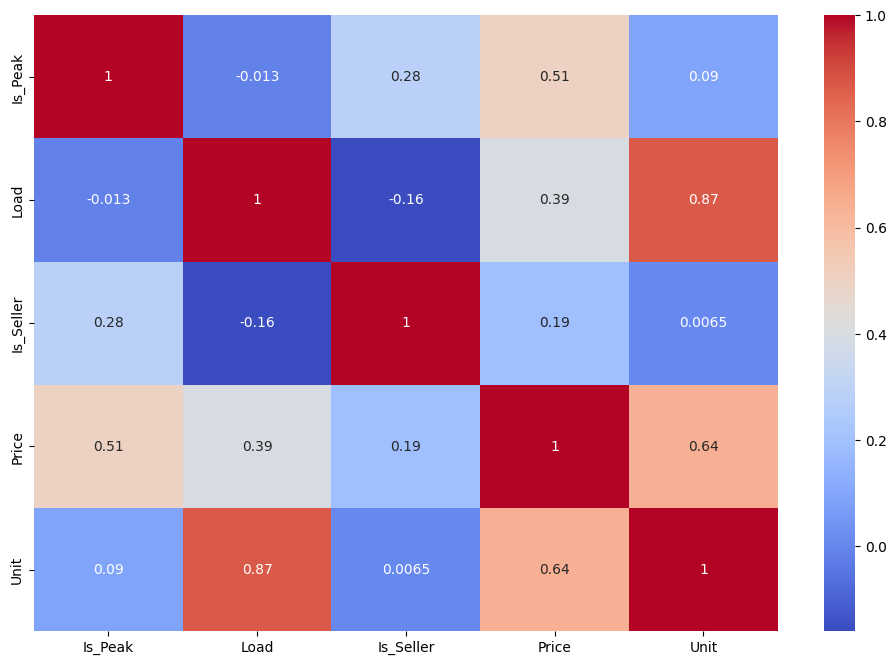

In [11]:
numerical_columns = ['Is_Peak', 'Load', 'Is_Seller', 'Price', 'Unit']
plt.figure(figsize=(12, 8))
sns.heatmap(full_df[numerical_columns].corr(), annot=True, cmap='coolwarm')
plt.show()

## Mechanism selection 

## Activity of networks

### calculate number of participant

In [12]:

def calculate_number_participants(df):
    return len(df['User'].unique())


sum_participant_dict= {}


participant_dict3 = {}
participant_dict2 = {}
participant_dict1 = {}

for round_time in time_list:
    filtered_df_type3 = df_Type3[(df_Type3['time'] == round_time) & (df_Type3['Unit'] != 0)]
    unique_users3 = filtered_df_type3['User'].unique()
    num_participants3 = len(unique_users3)
    participant_dict3[round_time] = num_participants3

    filtered_df_type2 = df_Type2[(df_Type2['time'] == round_time) & (df_Type2['Unit'] != 0)]
    unique_users2 = filtered_df_type2['User'].unique()
    num_participants2 = len(unique_users2)
    participant_dict2[round_time] = num_participants2

    filtered_df_type1 = df_Type1[(df_Type1['time'] == round_time) & (df_Type1['Unit'] != 0)]
    unique_users1 = filtered_df_type1['User'].unique()
    num_participants1 = len(unique_users1)
    participant_dict1[round_time] = num_participants1
    sum_participant_dict[round_time] = num_participants1 + num_participants2 + num_participants3 
    sum_participant_list = list(sum_participant_dict.values())
sum_participant_list


[27,
 28,
 28,
 28,
 28,
 28,
 28,
 24,
 22,
 18,
 18,
 18,
 18,
 27,
 27,
 28,
 28,
 23,
 26,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 22,
 19,
 19,
 18,
 17,
 19,
 27,
 28,
 28,
 27,
 23,
 24,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 20,
 19,
 20,
 17,
 17,
 17,
 27,
 27,
 28,
 27,
 24,
 24,
 28,
 28,
 28,
 28,
 28]

### compare each round with its perivious round 

In [13]:
## To Do how can we calculate threshhold
alpha_percent = 0.8  
for round_time in time_list:
    current_participants = sum_participant_dict[round_time]
    previous_round = time_list.tolist()[time_list.tolist().index(round_time) - 1]
    previous_participants = sum_participant_dict[previous_round]
    threshold = alpha_percent * previous_participants
    if current_participants >= threshold:
        print(sum_participant_dict[round_time], round_time,  "Number od participants is within the expected range.")
    else:
        print(sum_participant_dict[round_time], round_time , "Number of participants is not within the expected range.")


27 4/5/2013 0:00 Number od participants is within the expected range.
28 4/5/2013 1:00 Number od participants is within the expected range.
28 4/5/2013 2:00 Number od participants is within the expected range.
28 4/5/2013 3:00 Number od participants is within the expected range.
28 4/5/2013 4:00 Number od participants is within the expected range.
28 4/5/2013 5:00 Number od participants is within the expected range.
28 4/5/2013 6:00 Number od participants is within the expected range.
24 4/5/2013 7:00 Number od participants is within the expected range.
22 4/5/2013 8:00 Number od participants is within the expected range.
18 4/5/2013 9:00 Number od participants is within the expected range.
18 4/5/2013 10:00 Number od participants is within the expected range.
18 4/5/2013 11:00 Number od participants is within the expected range.
18 4/5/2013 12:00 Number od participants is within the expected range.
27 4/5/2013 13:00 Number od participants is within the expected range.
27 4/5/2013 14:0

### Calculate number of units

In [14]:

sum_unit_dict= {}
sum_units = {}
diff_units = {}
unit_dict1 = {}
unit_dict2 = {}
unit_dict3 = {}

for round_time in time_list:
    filtered_df_type3 = df_Type3[(df_Type3['time'] == round_time)]
    unique_users3 = filtered_df_type3['User'].unique()
    num_units_buyer3 = filtered_df_type3[filtered_df_type3['Is_Seller'] == False]['Unit'].sum()
    num_units_seller3 = filtered_df_type3[filtered_df_type3['Is_Seller'] == True]['Unit'].sum()
    sum_units3 = num_units_buyer3 + num_units_seller3
    unit_dict3[round_time] = [num_units_buyer3 , num_units_seller3 , sum_units3]

    filtered_df_type2 = df_Type2[(df_Type2['time'] == round_time)]
    unique_users2 = filtered_df_type2['User'].unique()
    num_units_buyer2 = filtered_df_type2[filtered_df_type2['Is_Seller'] == False]['Unit'].sum()
    num_units_seller2 = filtered_df_type2[filtered_df_type2['Is_Seller'] == True]['Unit'].sum()
    sum_units2 = num_units_buyer2 + num_units_seller2
    unit_dict2[round_time] = [num_units_buyer2 , num_units_seller2 , sum_units2]

    filtered_df_type1 = df_Type1[(df_Type1['time'] == round_time)]
    unique_users1 = filtered_df_type1['User'].unique()
    num_units_buyer1 = filtered_df_type1[filtered_df_type1['Is_Seller'] == False]['Unit'].sum()
    num_units_seller1 = filtered_df_type1[filtered_df_type1['Is_Seller'] == True]['Unit'].sum()
    sum_units1 = num_units_buyer1 + num_units_seller1
    unit_dict1[round_time] = [num_units_buyer1 , num_units_seller1 , sum_units1]

    num_units_buyers = num_units_buyer1+num_units_buyer2 + num_units_buyer3
    num_units_sellers = num_units_seller1+num_units_seller2 + num_units_seller3
    num_sum_units = sum_units1+sum_units2+ sum_units3 
    num_diff_units = abs(1/(num_units_buyers - num_units_sellers))

    sum_unit_dict[round_time] = {'num_units_buyers':num_units_buyers , 'num_units_sellers':num_units_sellers, 'sum_units':num_sum_units,'diff_units':num_diff_units}
    sum_units[round_time] = num_sum_units
    diff_units[round_time] = num_diff_units
    sum_units_list = list(sum_units.values())
    diff_units_list = list(diff_units.values())
sum_units_list


[13016.0,
 13329.0,
 18817.0,
 23699.0,
 18640.0,
 18365.0,
 18651.0,
 16665.85967332,
 16749.263629148998,
 5299.68316256,
 7975.851887389999,
 8455.56701246,
 8795.28959085,
 36356.8884804,
 13800.321070960003,
 12900.75900616,
 9680.60042005,
 5822.37822416,
 10759.75863135,
 19266.55952359,
 23127.0,
 23518.0,
 15974.0,
 14927.0,
 12463.0,
 15224.0,
 16598.0,
 22905.0,
 18341.0,
 20296.0,
 19747.0,
 14859.128970369999,
 9786.16857552,
 6198.2893159800005,
 10987.1069273,
 12848.39947513,
 12738.0258825,
 34649.66553863,
 13371.57778304,
 17946.91991862,
 11760.4349458,
 11651.23636903,
 18310.047411624,
 16771.049626300002,
 18070.0,
 20405.0,
 19192.0,
 16449.0,
 13241.0,
 13990.0,
 16052.0,
 23228.0,
 18622.0,
 18290.0,
 17841.0,
 15229.10014331,
 9324.82504852,
 7564.13118877,
 7357.2825582,
 12112.4012787,
 8601.4874177,
 38546.148645299996,
 15155.2690692,
 13822.635736426,
 13324.307806190001,
 10957.959827080002,
 19043.33172306,
 18039.3280279,
 18198.0,
 18257.0,
 17558.0,

### Compare each number of units with its average from start to current round_time

In [15]:
## To Do how can we calculate threshhold
alpha_percent = 0.8
return_zero_if_negative = lambda x: 0 if x < 0 else x
moving_average_period=5
for i,round_time in enumerate(time_list):
    sum_previous_units = np.mean([sum['sum_units'] for sum in sum_unit_dict.values()][return_zero_if_negative(i-moving_average_period):i+1])
    print(sum_previous_units , i)
# sum_previous_units

13016.0 0
13172.5 1
15054.0 2
17215.25 3
17500.2 4
17644.333333333332 5
18583.5 6
19139.643278886666 7
18795.0205504115 8
15728.467744171501 9
13951.109725403168 10
12299.537560813165 11
10656.919159288167 12
13938.757293801498 13
13447.266867436667 14
14714.112841369999 15
14998.237596813335 16
14559.372798763334 17
14886.784305513333 18
12038.396146045001 19
13592.842634218332 20
15362.382799858335 21
16411.28272985 22
17928.71969249 23
18212.593253931667 24
17538.833333333332 25
16450.666666666668 26
16348.5 27
16743.0 28
17637.833333333332 29
18851.833333333332 30
18791.02149506167 31
17655.716257648335 32
14871.264476978335 33
13645.615631528335 34
12404.348877383336 35
11236.186524466664 36
14534.609285843331 37
15132.177487096667 38
17090.282587536665 39
17219.170590619997 40
17019.64340627 41
17948.313661124 42
14968.54434240233 43
15751.614711895667 44
16161.294725459002 45
17399.888901159 46
18199.516172987333 47
17354.674937716667 48
16891.166666666668 49
16554.833333333332 

## Normalized

In [16]:
def NormalizeData(data: np.ndarray) -> np.ndarray:
    return (data - np.min(data)) / (np.max(data) - np.min(data))



## Weighting

In [17]:
values_lists = [NormalizeData(sum_units_list), NormalizeData(sum_participant_list), NormalizeData(diff_units_list)]


### Equal weighting

In [18]:
equal_weightings_Bool = False
weight_list = [1, 1, 1]
# we want to calculate the results by weighting the 
def equal_weightings(values_lists , weight_list):
    for values_list in zip(*values_lists):
        sum = 0
        for w,v in zip(weight_list,values_list):
            sum+=w*v
            direct_output = sum/len(weight_list)
            if direct_output > 0.5:
                equal_weightings_Bool = True
                # print(direct_output, "The results are within the expected range.")
            else:
                equal_weightings_Bool =  False
                # print(direct_output, "The results are not within the expected range.")
    return equal_weightings_Bool

### Direct ranking

In [19]:
direct_ranking_Bool = False
weight_list = [0.5, 0.3, 0.2]
def direct_ranking(values_lists , weight_list):
    for values_list in zip(*values_lists):
        sum = 0
        for w,v in zip(weight_list,values_list):
            sum+=w*v
            direct_output = sum/len(weight_list)
            if direct_output > 0.5:
                direct_ranking_Bool = True
                # print(direct_output, "The results in direct_output are within the expected range.")
            else:
                direct_ranking_Bool =  False
                # print(direct_output, "The results in direct_output are not within the expected range.")
    return direct_ranking_Bool

### Swing weighting

### Affordable for VCG

In [20]:
Beta = 0.7
def Is_Affordable(previous_auctioneer_profit , current_pay_vcg):
    if Beta*previous_auctioneer_profit > current_pay_vcg:
        return True
    else:
        return False

In [21]:
def mechanism_selctor(
    bm_list: List[BidManager], tm_list: List[TransactionManager]
) -> Type[Mechanism]:
    if len(tm_list) == 0:
        previous_auctioneer_profit=0.0
    else:
        previous_auctioneer_profit=tm_list[-1].get_auctioneer_profit()
    incoming_round_vcg_auctioneer_profit=bm_list[-1].run(VCG_Mechanism_Multi)[1].get_auctioneer_profit()

    # print(previous_auctioneer_profit, incoming_round_vcg_auctioneer_profit)
    if equal_weightings(values_lists, weight_list):
        # print("Trade reduction")
        return TradeReduction_mechanism_Multi
    else:
        if Is_Affordable(previous_auctioneer_profit,incoming_round_vcg_auctioneer_profit):
            return VCG_Mechanism_Multi
        else:
            return Average_Mechanism_Multi

## Run Round

In [22]:
bm = BidManager()
# if df_Type1['time'] == "04/05/2013  12:00:00 ق.ظ":
# for i in range (0,10):
tm_list = []
bm_list = []
for round_time in time_list:
    df_Type3_filtered = df_Type3[df_Type3['time'] == round_time]
    df_Type2_filtered = df_Type2[df_Type2['time'] == round_time]
    df_Type1_filtered = df_Type1[df_Type1['time'] == round_time]
    df_round = pd.concat([df_Type3_filtered, df_Type2_filtered, df_Type1_filtered], ignore_index=True)
    for index , row  in df_round.iterrows():
        bm.add_bid(Bid(user_id =row['User'],price=row['Price'], quantity= row['Unit'], buying=not row['Is_Seller'],time= row['time']))
    bm_list.append(bm)
    ## mechanism selection
    mechanism = mechanism_selctor(bm_list, tm_list)
    bm_new, tm = bm.run(mechanism)
    bm_new2 , tm2 = bm_new.run(Leftover_Clear, P_fit , p_G)
    bm_list.append(bm_new)
    tm_list.append(tm)
    tm_list.append(tm2)
    bm = bm_new2

    print(round_time)
    print(mechanism)


4/5/2013 0:00
Average_Mechanism_Multi
4/5/2013 1:00
Average_Mechanism_Multi
4/5/2013 2:00
Average_Mechanism_Multi
4/5/2013 3:00
Average_Mechanism_Multi
4/5/2013 4:00
Average_Mechanism_Multi
4/5/2013 5:00
Average_Mechanism_Multi
4/5/2013 6:00
Average_Mechanism_Multi
4/5/2013 7:00
Average_Mechanism_Multi
4/5/2013 8:00
Average_Mechanism_Multi
4/5/2013 9:00
Average_Mechanism_Multi
4/5/2013 10:00
Average_Mechanism_Multi
4/5/2013 11:00
Average_Mechanism_Multi
4/5/2013 12:00
Average_Mechanism_Multi
4/5/2013 13:00
Average_Mechanism_Multi
4/5/2013 14:00
Average_Mechanism_Multi
4/5/2013 15:00
Average_Mechanism_Multi
4/5/2013 16:00
Average_Mechanism_Multi
4/5/2013 17:00
Average_Mechanism_Multi
4/5/2013 18:00
Average_Mechanism_Multi
4/5/2013 19:00
Average_Mechanism_Multi
4/5/2013 20:00
Average_Mechanism_Multi
4/5/2013 21:00
Average_Mechanism_Multi
4/5/2013 22:00
Average_Mechanism_Multi
4/5/2013 23:00
Average_Mechanism_Multi
4/6/2013 0:00
Average_Mechanism_Multi
4/6/2013 1:00
Average_Mechanism_Mult